In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
import joblib
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# 1. Load Data
print("Loading data...")
# Read the file directly
df = pd.read_csv("selected_features_dataset.csv")

# Check what we have
print(df.shape)
print(df['Label'].value_counts())

Loading data...
(225709, 25)
Label
1    128025
0     97684
Name: count, dtype: int64


In [3]:
# 2. Preprocessing

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Fix labels if they are strings (BENIGN -> 0, DDoS -> 1)
# Simple check
if y.dtype == 'object':
    print("Converting labels to numbers...")
    y = y.replace({'BENIGN': 0, 'DDoS': 1})

# Split the data
# We use stratify to keep the same % of attacks in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Scale the data (Make numbers on same scale)
scaler = RobustScaler()
# Fit on train, transform both
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Reset index to make sure everything matches up
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Training data shape: (157996, 24)
Test data shape: (67713, 24)


Training XGBoost...
Weight for imbalance: 0.7630137139158865
XGBoost trained!
Evaluating XGBoost...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29305
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67713
   macro avg       1.00      1.00      1.00     67713
weighted avg       1.00      1.00      1.00     67713



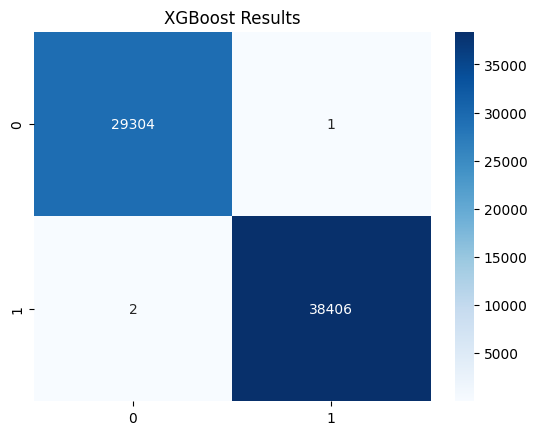

In [4]:
# 3. XGBoost Model (High Accuracy)
print("Training XGBoost...")

# Count classes to handle imbalance
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos
print("Weight for imbalance:", scale_pos_weight)

# Create and train the model
xgb_model = XGBClassifier(
    n_estimators=100, 
    max_depth=8, 
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
print("XGBoost trained!")

# Check how it did
print("Evaluating XGBoost...")
xgb_pred = xgb_model.predict(X_test_scaled)

# Print report
print(classification_report(y_test, xgb_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Results")
plt.show()

In [5]:
# 4. Deep Neural Network (DNN)

# We need to compute class weights for the neural network too
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

# Split train again for validation (so we know when to stop training)
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(
    X_train_scaled, y_train, test_size=0.15, random_state=42, stratify=y_train
)

input_dim = X_train_scaled.shape[1]
print("Input features:", input_dim)

Class weights: {0: np.float64(1.15529621667471), 1: np.float64(0.8815068569579433)}
Input features: 24


In [6]:
# Build the Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_dim,)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # 1 output: 0 or 1

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_dnn, y_train_dnn,
    epochs=100, # Beginner might use less epochs or just let it run
    batch_size=256,
    validation_data=(X_val_dnn, y_val_dnn),
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

print("DNN trained.")

Epoch 1/100


c:\Users\MARX\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9624 - loss: 0.1216 - val_accuracy: 0.9719 - val_loss: 0.1052
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9935 - loss: 0.0267 - val_accuracy: 0.9669 - val_loss: 0.1132
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9952 - loss: 0.0193 - val_accuracy: 0.9966 - val_loss: 0.0137
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9960 - loss: 0.0156 - val_accuracy: 0.9961 - val_loss: 0.0201
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9967 - loss: 0.0132 - val_accuracy: 0.9988 - val_loss: 0.0081
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9965 - loss: 0.0138 - val_accuracy: 0.9961 - val_loss: 0.0218
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9962 - loss: 0.0144 - val_accuracy: 0.9979 - val_loss: 0.0216
Epoch 8/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9977 - loss: 0.0094 - val_accuracy: 0.9989

Optimizing threshold...


2117/2117 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step
Best Threshold found: 0.17272727272727273
Best F1 Score: 0.9992836209703679
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29305
           1       1.00      1.00      1.00     38408

    accuracy                           1.00     67713
   macro avg       1.00      1.00      1.00     67713
weighted avg       1.00      1.00      1.00     67713



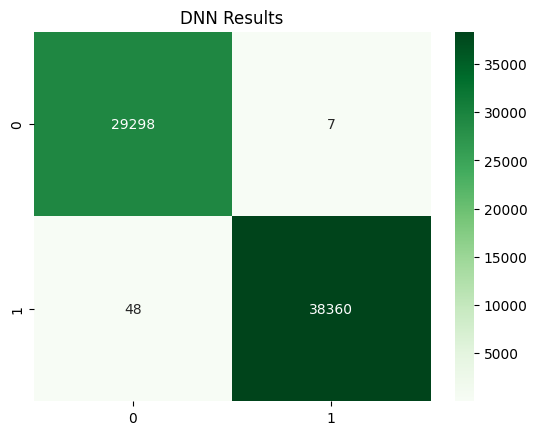

In [7]:
# Find best threshold for DNN
# Neural net gives probability (0.1, 0.9 etc), we need to decide where to cut off (0 or 1)
print("Optimizing threshold...")
y_proba = model.predict(X_test_scaled).flatten()

best_f1 = 0
best_threshold = 0.5

# Check many possible thresholds
for tr in np.linspace(0.1, 0.9, 100):
    preds = (y_proba >= tr).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = tr

print("Best Threshold found:", best_threshold)
print("Best F1 Score:", best_f1)

# Final DNN predictions
dnn_preds = (y_proba >= best_threshold).astype(int)

# Show results
print(classification_report(y_test, dnn_preds))
cm = confusion_matrix(y_test, dnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("DNN Results")
plt.show()

Running full pipeline...
Pipeline finished.

Signature-Based Detection Results (Standalone)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     29305
           1       0.97      0.99      0.98     38408

    accuracy                           0.98     67713
   macro avg       0.98      0.98      0.98     67713
weighted avg       0.98      0.98      0.98     67713



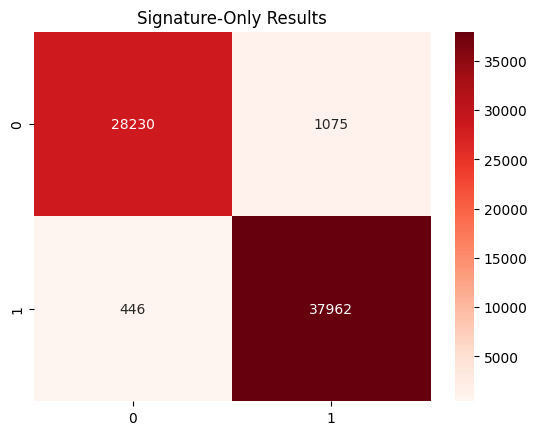


Final Pipeline Results
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     29305
           1       0.97      1.00      0.99     38408

    accuracy                           0.98     67713
   macro avg       0.99      0.98      0.98     67713
weighted avg       0.98      0.98      0.98     67713



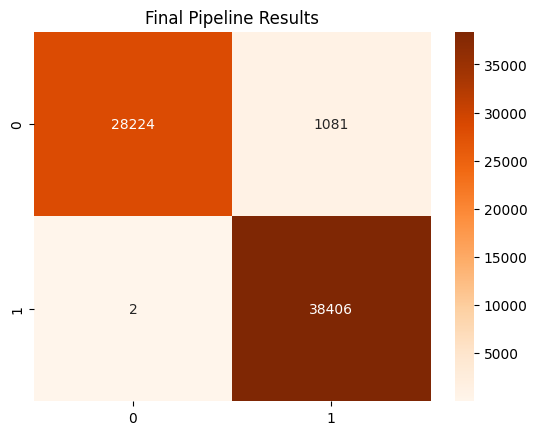

In [8]:
# 5. Full Pipeline (Signature + XGBoost + DNN)
# We loop through test data and check rules one by one

print("Running full pipeline...")
final_predictions = []
signature_predictions = []

# We need unscaled data for rules (raw numbers) and scaled for AI
X_test_numpy = X_test.values 
X_test_scaled_numpy = X_test_scaled.values

# Pre-calculate DNN results to be fast
dnn_probs = model.predict(X_test_scaled, verbose=0).flatten()
dnn_decisions = (dnn_probs >= best_threshold).astype(int)

# Loop over every row
for i in range(len(X_test)):
    # Get the row
    row = X_test.iloc[i] # Unscaled (Series)
    
    # --- 1. Signature Rules (Simple If Statements) ---
    is_attack = 0
    
    # Get values needed
    fwd_len_mean = row.get('Fwd Packet Length Mean', 0)
    fwd_pkts = row.get('Total Fwd Packets', 0)
    init_win = row.get('Init_Win_bytes_forward', -1)
    duration = row.get('Flow Duration', 0)
    
    # Rule 1: Small packets + burst
    if 0 < fwd_len_mean < 18 and fwd_pkts > 2:
        is_attack = 1
    # Rule 2: Init Window
    elif init_win == 0:
        is_attack = 1
    # Rule 3: Too many packets
    elif fwd_pkts > 100:
        is_attack = 1
    # Rule 4: Fast attack
    elif duration < 50 and fwd_pkts > 10:
        is_attack = 1
        
    signature_predictions.append(is_attack)
    
    if is_attack == 1:
        final_predictions.append(1) # Blocked by Signature
        continue # Skip to next 
        
    # --- 2. XGBoost Check ---
    # We need to reshape the row for model
    # row_scaled = X_test_scaled.iloc[[i]] 
    # But for speed in this loop we can use the array
    # Note: iterating rows is slow in Python, but simpler to understand
    
    xgb_res = xgb_model.predict(X_test_scaled.iloc[[i]])[0]
    if xgb_res == 1:
        final_predictions.append(1) # Blocked by XGBoost
        continue
        
    # --- 3. DNN Check ---
    # If we are here, previous checks said "Benign"
    final_predictions.append(dnn_decisions[i])

print("Pipeline finished.")

# Signature Results
print("\nSignature-Based Detection Results (Standalone)")
print(classification_report(y_test, signature_predictions))
cm_sig = confusion_matrix(y_test, signature_predictions)
plt.figure()
sns.heatmap(cm_sig, annot=True, fmt='d', cmap='Reds')
plt.title("Signature-Only Results")
plt.show()

# Final Results
print("\nFinal Pipeline Results")
print(classification_report(y_test, final_predictions))
cm = confusion_matrix(y_test, final_predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Final Pipeline Results")
plt.show()

In [9]:

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
print("Saving models...")

# 1. Save Scaler (Important for preprocessing new data)

joblib.dump(scaler, 'models/scaler.pkl')
print("- Scaler saved to models/scaler.pkl")

# 2. Save XGBoost Model
joblib.dump(xgb_model, 'models/ddos_xgboost.pkl')
print("- XGBoost model saved to models/ddos_xgboost.pkl")

# 3. Save DNN Model (Keras format)
model.save('models/dnn_classifier.keras')
print("- DNN model saved to models/dnn_classifier.keras")


print("All models saved successfully!")

Saving models...
- Scaler saved to models/scaler.pkl
- XGBoost model saved to models/ddos_xgboost.pkl


- DNN model saved to models/dnn_classifier.keras
All models saved successfully!
